<a href="https://colab.research.google.com/github/Pitap4ik/Stock-market-prerdictions/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1473]:
import yfinance as yf
import pandas as pd
import os
import numpy as np

In [1474]:
from google.colab import files
uploaded = files.upload()

Saving ETHUSDT_daily_binance.xlsx to ETHUSDT_daily_binance (2).xlsx


In [2491]:
# if os.path.exists("D:\Ass2\ETHUSDT_1h_latest.csv"):
#     sp500 = pd.read_csv("D:\Ass2\ETHUSDT_1h_latest.csv", index_col=0)
# else:
#     sp500 = yf.Ticker("^GSPC")
#     sp500 = sp500.history(period="max")
#     sp500.to_csv("sp500.csv")

In [2492]:
sp500 = pd.read_excel("ETHUSDT_daily_binance (2).xlsx")

In [2493]:
#sp500.index = pd.to_datetime(sp500.index)
sp500.columns = [col.capitalize() for col in sp500.columns]
sp500['Close']=[float(x) for x in sp500['Close']]
sp500['Volume']=[float(x) for x in sp500['Volume']]
sp500['Open']=[float(x) for x in sp500['Open']]
sp500['High']=[float(x) for x in sp500['High']]
sp500['Low']=[float(x) for x in sp500['Low']]
#sp500 = sp500.drop('Volume', axis=1)

In [2494]:
!pip install ta
import ta
sp500['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(
    high=sp500['High'],
    low=sp500['Low'],
    close=sp500['Close'],
    volume=sp500['Volume'],
    window=20
).chaikin_money_flow()

In [2495]:
sp500['VPT'] = (sp500['Volume'] * (sp500['Close'].pct_change())).cumsum()

In [2496]:
#sp500['OBV'] = (np.sign(sp500['Close'].diff()) * sp500['Volume']).fillna(0).cumsum()

In [2497]:
#sp500['OBV_previus'] = (np.sign(sp500['Close'].shift(1).diff()) * sp500['Volume'].shift(1)).fillna(0).cumsum()

In [2498]:
for i in range(20):
  vpt=f"VPT_{i}"
  sp500[vpt] = (sp500['Volume'].shift(i+1) * (sp500['Close'].shift(i+1).pct_change())).cumsum()

In [2499]:
sp500['Williams_R'] = ((sp500['High'].rolling(window=14).max() - sp500['Close']) /
                     (sp500['High'].rolling(window=14).max() - sp500['Low'].rolling(window=14).min())) * -100

In [2500]:
def calculate_parabolic_sar(df, af_start=0.02, af_increment=0.02, af_max=0.2):
    high = df['High']
    low = df['Low']
    close = df['Close']

    # Initialization
    sar = [low.iloc[0]]  # Start SAR at the first low
    uptrend = True  # Assume starting with uptrend
    af = af_start  # Acceleration Factor
    ep = high.iloc[0]  # Extreme Point

    for i in range(1, len(df)):
        prev_sar = sar[-1]

        if uptrend:
            new_sar = prev_sar + af * (ep - prev_sar)
            new_sar = min(new_sar, low.iloc[i-1], low.iloc[i])  # SAR cannot be above last two lows
        else:
            new_sar = prev_sar - af * (prev_sar - ep)
            new_sar = max(new_sar, high.iloc[i-1], high.iloc[i])  # SAR cannot be below last two highs

        reverse = False
        if uptrend:
            if low.iloc[i] < new_sar:
                uptrend = False
                reverse = True
                new_sar = ep
                ep = low.iloc[i]
                af = af_start
        else:
            if high.iloc[i] > new_sar:
                uptrend = True
                reverse = True
                new_sar = ep
                ep = high.iloc[i]
                af = af_start

        if not reverse:
            if uptrend:
                if high.iloc[i] > ep:
                    ep = high.iloc[i]
                    af = min(af + af_increment, af_max)
            else:
                if low.iloc[i] < ep:
                    ep = low.iloc[i]
                    af = min(af + af_increment, af_max)

        sar.append(new_sar)

    df['Parabolic_SAR'] = sar
    return df

In [2501]:
sp500 = calculate_parabolic_sar(sp500)

In [2502]:
sp500["Parabolic_SAR"]=sp500["Close"]/sp500["Parabolic_SAR"]

In [2503]:
sp500

,Timestamp,Open,High,Low,Close,Volume,CMF,VPT,VPT_0,VPT_1,...,VPT_12,VPT_13,VPT_14,VPT_15,VPT_16,VPT_17,VPT_18,VPT_19,Williams_R,Parabolic_SAR
0,2019-11-07 00:00:00,191.16,192.27,184.59,186.68,309882.08206,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.011322
1,2019-11-08 00:00:00,186.67,188.26,181.41,183.74,365029.75027,NaN,-5.748808e+03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.012844
2,2019-11-09 00:00:00,183.71,185.79,182.63,184.89,192073.38044,NaN,-4.546651e+03,-5.748808e+03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.019183
3,2019-11-10 00:00:00,184.86,191.58,183.30,188.96,274940.53448,NaN,1.505640e+03,-4.546651e+03,-5.748808e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.040373
4,2019-11-11 00:00:00,188.96,190.19,184.06,184.98,255579.93429,NaN,-3.877553e+03,1.505640e+03,-4.546651e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.017268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2025-04-24 00:00:00,1795.08,1802.82,1722.90,1769.65,483465.03850,0.063698,1.630225e+06,1.637071e+06,1.617458e+06,...,1.491792e+06,1.474843e+06,1.555273e+06,1.293277e+06,1.339005e+06,1.377036e+06,1.499245e+06,1.500451e+06,-19.746843,1.027134
1996,2025-04-25 00:00:00,1769.64,1827.32,1738.60,1784.60,595610.88940,0.059212,1.635256e+06,1.630225e+06,1.637071e+06,...,1.516561e+06,1.491792e+06,1.474843e+06,1.555273e+06,1.293277e+06,1.339005e+06,1.377036e+06,1.499245e+06,-16.888441,1.035812
1997,2025-04-26 00:00:00,1784.60,1841.16,1778.94,1820.88,355068.04420,0.116548,1.642475e+06,1.635256e+06,1.630225e+06,...,1.500182e+06,1.516561e+06,1.491792e+06,1.474843e+06,1.555273e+06,1.293277e+06,1.339005e+06,1.377036e+06,-6.673248,1.047325
1998,2025-04-27 00:00:00,1820.87,1857.47,1781.90,1791.29,340332.64350,0.071447,1.636944e+06,1.642475e+06,1.635256e+06,...,1.510697e+06,1.500182e+06,1.516561e+06,1.491792e+06,1.474843e+06,1.555273e+06,1.293277e+06,1.339005e+06,-20.667687,1.006942


<Axes: >

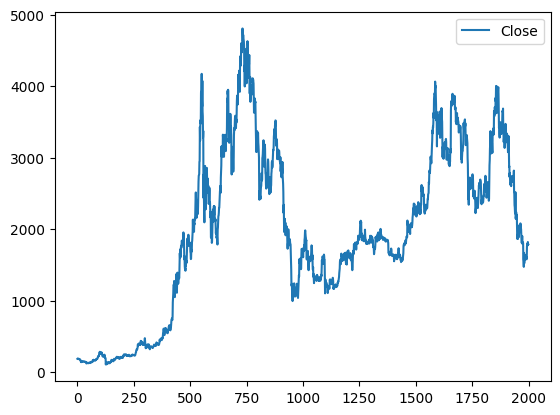

In [2504]:
sp500.plot.line(y="Close", use_index=True)

In [2505]:
# del sp500["Dividends"]
# del sp500["Stock Splits"]

In [2506]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)-sp500["Open"].shift(-1)

In [2507]:
sp500["Tomorrow_low"] = sp500["Low"].shift(-1)-sp500["Open"].shift(-1)

In [2508]:
sp500["Target"] = (sp500["Tomorrow"] >0).astype(int)

In [2509]:
sp500["Percent"] = sp500["Tomorrow"]/sp500["Close"]

In [2510]:
sp500["Percent_low"] = sp500["Tomorrow_low"]/sp500["Close"]

In [2511]:
def calculate_rsi(df, period=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_stochrsi(df, period=14, smooth_period=3):
    rsi = calculate_rsi(df, period)
    rsi_min = rsi.rolling(window=period).min()
    rsi_max = rsi.rolling(window=period).max()
    stochrsi = (rsi - rsi_min) / (rsi_max - rsi_min)
    stochrsi_smooth = stochrsi.rolling(window=smooth_period).mean()  # Optional smoothing
    return stochrsi_smooth

In [2512]:
sp500['TP'] = (sp500['High'] + sp500['Low'] + sp500['Close']) / 3
sp500['CCI'] = (sp500['TP'] - sp500['TP'].rolling(window=20).mean()) / (0.015 * sp500['TP'].rolling(window=20).std())

In [2513]:
sp500["Stoch_RSI"] = calculate_stochrsi(sp500)

In [2514]:
for i in range(20):
  RSI=f"Stoch_RSI_{i}"
  sp500[RSI] = sp500["Stoch_RSI"].shift(i+1)

In [2515]:
sp500

,Timestamp,Open,High,Low,Close,Volume,CMF,VPT,VPT_0,VPT_1,...,Stoch_RSI_10,Stoch_RSI_11,Stoch_RSI_12,Stoch_RSI_13,Stoch_RSI_14,Stoch_RSI_15,Stoch_RSI_16,Stoch_RSI_17,Stoch_RSI_18,Stoch_RSI_19
0,2019-11-07 00:00:00,191.16,192.27,184.59,186.68,309882.08206,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-11-08 00:00:00,186.67,188.26,181.41,183.74,365029.75027,NaN,-5.748808e+03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-09 00:00:00,183.71,185.79,182.63,184.89,192073.38044,NaN,-4.546651e+03,-5.748808e+03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-11-10 00:00:00,184.86,191.58,183.30,188.96,274940.53448,NaN,1.505640e+03,-4.546651e+03,-5.748808e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-11-11 00:00:00,188.96,190.19,184.06,184.98,255579.93429,NaN,-3.877553e+03,1.505640e+03,-4.546651e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2025-04-24 00:00:00,1795.08,1802.82,1722.90,1769.65,483465.03850,0.063698,1.630225e+06,1.637071e+06,1.617458e+06,...,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076,0.160931,0.117326
1996,2025-04-25 00:00:00,1769.64,1827.32,1738.60,1784.60,595610.88940,0.059212,1.635256e+06,1.630225e+06,1.637071e+06,...,0.785261,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076,0.160931
1997,2025-04-26 00:00:00,1784.60,1841.16,1778.94,1820.88,355068.04420,0.116548,1.642475e+06,1.635256e+06,1.630225e+06,...,0.773290,0.785261,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076
1998,2025-04-27 00:00:00,1820.87,1857.47,1781.90,1791.29,340332.64350,0.071447,1.636944e+06,1.642475e+06,1.635256e+06,...,0.815699,0.773290,0.785261,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605


In [2516]:
# sp500.index = pd.to_datetime(sp500.index, utc=True)
# sp500 = sp500.loc["1990-01-01":].copy()

In [2517]:
sp500

,Timestamp,Open,High,Low,Close,Volume,CMF,VPT,VPT_0,VPT_1,...,Stoch_RSI_10,Stoch_RSI_11,Stoch_RSI_12,Stoch_RSI_13,Stoch_RSI_14,Stoch_RSI_15,Stoch_RSI_16,Stoch_RSI_17,Stoch_RSI_18,Stoch_RSI_19
0,2019-11-07 00:00:00,191.16,192.27,184.59,186.68,309882.08206,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-11-08 00:00:00,186.67,188.26,181.41,183.74,365029.75027,NaN,-5.748808e+03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-09 00:00:00,183.71,185.79,182.63,184.89,192073.38044,NaN,-4.546651e+03,-5.748808e+03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-11-10 00:00:00,184.86,191.58,183.30,188.96,274940.53448,NaN,1.505640e+03,-4.546651e+03,-5.748808e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-11-11 00:00:00,188.96,190.19,184.06,184.98,255579.93429,NaN,-3.877553e+03,1.505640e+03,-4.546651e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2025-04-24 00:00:00,1795.08,1802.82,1722.90,1769.65,483465.03850,0.063698,1.630225e+06,1.637071e+06,1.617458e+06,...,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076,0.160931,0.117326
1996,2025-04-25 00:00:00,1769.64,1827.32,1738.60,1784.60,595610.88940,0.059212,1.635256e+06,1.630225e+06,1.637071e+06,...,0.785261,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076,0.160931
1997,2025-04-26 00:00:00,1784.60,1841.16,1778.94,1820.88,355068.04420,0.116548,1.642475e+06,1.635256e+06,1.630225e+06,...,0.773290,0.785261,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076
1998,2025-04-27 00:00:00,1820.87,1857.47,1781.90,1791.29,340332.64350,0.071447,1.636944e+06,1.642475e+06,1.635256e+06,...,0.815699,0.773290,0.785261,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605


In [2518]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Open", "High", "Low","Stoch_RSI",'CCI', "Volume",'Williams_R','Parabolic_SAR']#'Parabolic_SAR']
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [2519]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4722222222222222

<Axes: >

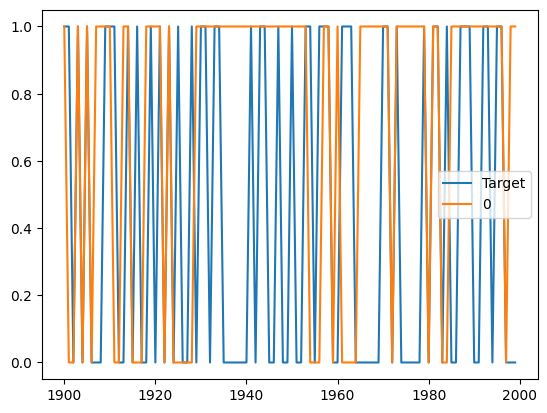

In [2520]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [2521]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [2522]:
def backtest(data, model, predictors, start=900, step=50):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [2523]:
predictions = backtest(sp500, model, predictors)

In [2524]:
predictions["Predictions"].value_counts()

,count
Predictions,
1,638
0,462


In [2525]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5047021943573667

In [2526]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
0,0.504545
1,0.495455


In [2527]:
horizons = [50,200]
new_predictors = ['VPT','Parabolic_SAR','CMF',"Stoch_RSI"]#"Close", "Open", "High", "Low","Stoch_RSI",'CCI', "Volume",'OBV','Williams_R','Parabolic_SAR']'OBV_previus'
for i in range(20):
  new_predictors.append(f'VPT_{i}')
  new_predictors.append(f"Stoch_RSI_{i}")
# for horizon in horizons:
#     rolling_averages = sp500[['Close']].rolling(horizon).mean()

#     ratio_column = f"Close_Ratio_{horizon}"
#     sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
# #     print(rolling_averages.columns)


#     # obv_avarage = sp500[['OBV']].rolling(horizon).mean()

#     # obv_ratio = f"OBV_Ratio_{horizon}"

#     # sp500[obv_ratio] = sp500["Close"].diff()*sp500['Volume']/ obv_avarage["OBV"]

#     # ex_avarages= sp500['Close'].ewm(span=horizon, adjust=False).mean()

#     # ex_ratio_column = f"Close_Ratio_EW_{horizon}"
#     # sp500[ex_ratio_column] = sp500["Close"] / ex_avarages

#     # trend_column = f"Trend_{horizon}"
#     # sp500[trend_column] = sp500['Target'].shift(1).rolling(horizon).sum()

#     new_predictors+= [ratio_column] #trend_column]ratio_column

In [2528]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [2529]:
sp500

,Timestamp,Open,High,Low,Close,Volume,CMF,VPT,VPT_0,VPT_1,...,Stoch_RSI_10,Stoch_RSI_11,Stoch_RSI_12,Stoch_RSI_13,Stoch_RSI_14,Stoch_RSI_15,Stoch_RSI_16,Stoch_RSI_17,Stoch_RSI_18,Stoch_RSI_19
48,2019-12-25 00:00:00,127.70,127.84,123.07,125.09,225004.49090,-0.031582,-1.340212e+05,-1.293361e+05,-1.292576e+05,...,0.192588,0.225100,0.370231,0.493017,0.754952,0.867138,0.960852,0.960852,0.928596,0.841136
49,2019-12-26 00:00:00,125.09,132.26,124.32,125.58,274986.52097,-0.077447,-1.329440e+05,-1.340212e+05,-1.293361e+05,...,0.127046,0.192588,0.225100,0.370231,0.493017,0.754952,0.867138,0.960852,0.960852,0.928596
50,2019-12-27 00:00:00,125.58,127.10,121.91,126.29,240012.37451,-0.028875,-1.315870e+05,-1.329440e+05,-1.340212e+05,...,0.090177,0.127046,0.192588,0.225100,0.370231,0.493017,0.754952,0.867138,0.960852,0.960852
51,2019-12-28 00:00:00,126.28,129.68,125.84,128.11,196893.52277,-0.042950,-1.287495e+05,-1.315870e+05,-1.329440e+05,...,0.051291,0.090177,0.127046,0.192588,0.225100,0.370231,0.493017,0.754952,0.867138,0.960852
52,2019-12-29 00:00:00,128.11,138.07,127.52,134.36,316347.26666,0.000327,-1.133162e+05,-1.287495e+05,-1.315870e+05,...,0.131359,0.051291,0.090177,0.127046,0.192588,0.225100,0.370231,0.493017,0.754952,0.867138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,2025-04-23 00:00:00,1756.25,1834.86,1744.95,1795.07,887545.63160,0.077433,1.637071e+06,1.617458e+06,1.494073e+06,...,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076,0.160931,0.117326,0.175404
1995,2025-04-24 00:00:00,1795.08,1802.82,1722.90,1769.65,483465.03850,0.063698,1.630225e+06,1.637071e+06,1.617458e+06,...,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076,0.160931,0.117326
1996,2025-04-25 00:00:00,1769.64,1827.32,1738.60,1784.60,595610.88940,0.059212,1.635256e+06,1.630225e+06,1.637071e+06,...,0.785261,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076,0.160931
1997,2025-04-26 00:00:00,1784.60,1841.16,1778.94,1820.88,355068.04420,0.116548,1.642475e+06,1.635256e+06,1.630225e+06,...,0.773290,0.785261,0.719568,0.598506,0.458891,0.262042,0.126649,0.000000,0.043605,0.107076


In [2546]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=50, random_state=2)

In [2547]:
# def predict(train, test, predictors, model):
#     model.fit(train[predictors], train["Target"])
#     preds = model.predict_proba(test[predictors])[:,1]
#     real_preds = pd.Series(preds, index=test.index, name="Real_predictions")
#     preds[preds >=.54] = 1
#     preds[preds <.54] = 0
#     preds = pd.Series(preds, index=test.index, name="Predictions")
#     combined = pd.concat([test['Timestamp'], test["Target"], preds, real_preds, test["Percent"]], axis=1)
#     return combined

In [2548]:
def predict(train, test, predictors, model):
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])

    # Generate raw probability predictions
    preds = model.predict_proba(test[predictors])[:,1]

    # Create the "Real_predictions" Series from the raw probabilities
    real_preds = pd.Series(preds, index=test.index, name="Real_predictions")

    # Create a copy of the raw predictions to avoid modifying the original array
    preds_copy = preds.copy()

    # Apply thresholding to convert probabilities into binary predictions
    preds_copy[preds_copy >= .54] = 1
    preds_copy[preds_copy < .54] = 0

    # Create the "Predictions" Series from the thresholded predictions
    preds = pd.Series(preds_copy, index=test.index, name="Predictions")

    # Combine the results into a single DataFrame
    combined = pd.concat([test['Timestamp'], test["Target"], preds, real_preds, test["Percent"], test["Percent_low"], test["Stoch_RSI"]], axis=1)

    return combined

In [2549]:
predictions = backtest(sp500, model, new_predictors)

In [2550]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,624
1.0,427


In [2551]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5386416861826698

In [2552]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
0,0.501427
1,0.498573


In [2553]:
predictions=predictions[predictions['Predictions']==1]

In [2554]:
predictions["Timestamp"]=pd.to_datetime(predictions["Timestamp"])
predictions["Duration"]=predictions["Timestamp"].diff()

In [2555]:
predictions_copy=predictions.copy()

In [2556]:
predictions

,Timestamp,Target,Predictions,Real_predictions,Percent,Percent_low,Stoch_RSI,Duration
948,2022-06-12,0,1.0,0.621600,-0.156826,-0.187749,0.282032,NaT
949,2022-06-13,0,1.0,0.646135,-0.000372,-0.110388,0.027262,1 days
950,2022-06-14,1,1.0,0.630757,0.023674,-0.160890,0.005131,1 days
951,2022-06-15,0,1.0,0.622754,-0.136588,-0.150284,0.049287,1 days
952,2022-06-16,1,1.0,0.592082,0.017258,-0.016275,0.059747,1 days
...,...,...,...,...,...,...,...,...
1982,2025-04-11,1,1.0,0.612796,0.049354,-0.013269,0.458891,1 days
1983,2025-04-12,0,1.0,0.640244,-0.028239,-0.049982,0.598506,1 days
1984,2025-04-13,1,1.0,0.643035,0.016279,-0.001377,0.719568,1 days
1985,2025-04-14,0,1.0,0.636675,-0.021555,-0.025040,0.785261,1 days


In [2557]:
for i in range(len(predictions)):
  if predictions.iloc[i,4]*100<-1:
    print(predictions.iloc[i,0],predictions.iloc[i,3], predictions.iloc[i,4]*100,predictions.iloc[i,5]*100,predictions.iloc[i,6])

2022-06-12 00:00:00 0.6216001230865769 -15.682584817819409 -18.774915670039857 0.28203212312170856
2022-06-15 00:00:00 0.6227542277171008 -13.658769151205636 -15.028443984743683 0.0492873466554457
2022-06-17 00:00:00 0.579559315216169 -8.445728375071306 -18.894327193773357 0.08548201807199633
2022-06-21 00:00:00 0.5769295939961036 -6.721144024514798 -7.302038459830334 0.2006721639564563
2022-06-25 00:00:00 0.5892729453454755 -3.5835023664638257 -3.8402717408802634 0.7304661233329931
2022-06-27 00:00:00 0.5685895844140275 -4.063697579055944 -4.71191017266103 1.0
2022-06-28 00:00:00 0.5798852854009648 -3.832000349635061 -4.949958480835618 0.9753487969968507
2022-06-29 00:00:00 0.5444621760447478 -2.654038774415797 -9.290044627843779 0.9135952772418815
2022-06-30 00:00:00 0.5815170544589795 -1.0541451527063206 -3.5088374524981023 0.9135952772418815
2022-07-04 00:00:00 0.5746689533240726 -1.6081668114682879 -6.4874022589053055 0.8671613136704646
2022-07-07 00:00:00 0.5737016489094812 -1.89

In [2558]:
indexes_to_drop = []

# Loop through all rows except the last one
for i in range(len(predictions_copy) - 1):
    if (predictions.iloc[i+1, 0] - predictions.iloc[i, 0] == pd.Timedelta(days=1)):
        predictions.iloc[i+1, 4] = -1+((1 + predictions.iloc[i+1, 4]) * (1 + predictions.iloc[i, 4]))
        indexes_to_drop.append(predictions.index[i])  # Mark this row to drop

# After the loop, drop all marked rows
predictions.drop(index=indexes_to_drop, inplace=True)

In [2559]:
predictions

,Timestamp,Target,Predictions,Real_predictions,Percent,Percent_low,Stoch_RSI,Duration
973,2022-07-07,0,1.0,0.573702,-0.153536,-0.035831,0.919585,1 days
993,2022-07-27,1,1.0,0.569552,0.400600,-0.025964,0.900425,1 days
1003,2022-08-06,1,1.0,0.577663,0.050687,-0.013368,0.264599,1 days
1013,2022-08-16,0,1.0,0.670091,0.077216,-0.030869,0.656503,1 days
1021,2022-08-24,1,1.0,0.554745,0.053537,-0.001739,0.077028,1 days
...,...,...,...,...,...,...,...,...
1937,2025-02-25,0,1.0,0.581196,-0.139623,-0.096935,0.684495,1 days
1941,2025-03-01,1,1.0,0.574960,0.125363,-0.020456,0.073249,1 days
1954,2025-03-14,1,1.0,0.551652,-0.041205,-0.004127,0.535921,1 days
1979,2025-04-08,1,1.0,0.569501,0.133093,-0.059970,0.000000,25 days


In [2560]:
#predictions.plot()

In [2561]:
S = 100
for i in range(len(predictions)):
  print(predictions.iloc[i][4]*100, predictions.iloc[i][0])
  S=S*(1+(predictions.iloc[i][4]+0.0005)*3-0.001*3)
print(S)

-15.35361263377295 2022-07-07 00:00:00
40.06000342076857 2022-07-27 00:00:00
5.068733057690333 2022-08-06 00:00:00
7.721602546475004 2022-08-16 00:00:00
5.353704617413824 2022-08-24 00:00:00
4.07361206121819 2022-08-28 00:00:00
5.06674330579625 2022-09-08 00:00:00
-14.194491863642467 2022-09-14 00:00:00
-3.8034930866779337 2022-10-01 00:00:00
2.198646222669365 2022-10-04 00:00:00
-5.705336894677782 2022-10-14 00:00:00
17.814989160022932 2022-10-26 00:00:00
1.5484788140301298 2022-10-31 00:00:00
7.155882532311941 2022-11-04 00:00:00
-8.94707510443017 2022-11-20 00:00:00
7.464262440948266 2022-12-01 00:00:00
3.136613167165124 2022-12-03 00:00:00
7.269442804122339 2022-12-12 00:00:00
-2.2046353809816233 2022-12-27 00:00:00
4.540379655481286 2023-01-05 00:00:00
-0.9552288375300089 2023-02-04 00:00:00
11.820499871525158 2023-02-16 00:00:00
-1.1894779252752619 2023-02-20 00:00:00
-4.9773650745327025 2023-03-05 00:00:00
7.535135066726584 2023-03-13 00:00:00
1.2417275022173788 2023-03-18 00:00

<ipython-input-2561-766ad58b1a4a>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(predictions.iloc[i][4]*100, predictions.iloc[i][0])
<ipython-input-2561-766ad58b1a4a>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S=S*(1+(predictions.iloc[i][4]+0.0005)*3-0.001*3)
